# Energy Consumption Predictions using LSTM

In my previous notebook, I tried to forecast Mastercard share prices using LSTM: https://www.kaggle.com/code/mikolajhojda/mastercard-stock-price-predictions-using-lstm
It turned out that forecasting the stock  price is not a good application of LSTM. I decided to focus on data that has strong seasonality as in the case of electricity consumption.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [2]:
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv', index_col=[0], parse_dates=[0])

# Preprocessing

In [3]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df.rename(columns={'PJME_MW': 'Value'})

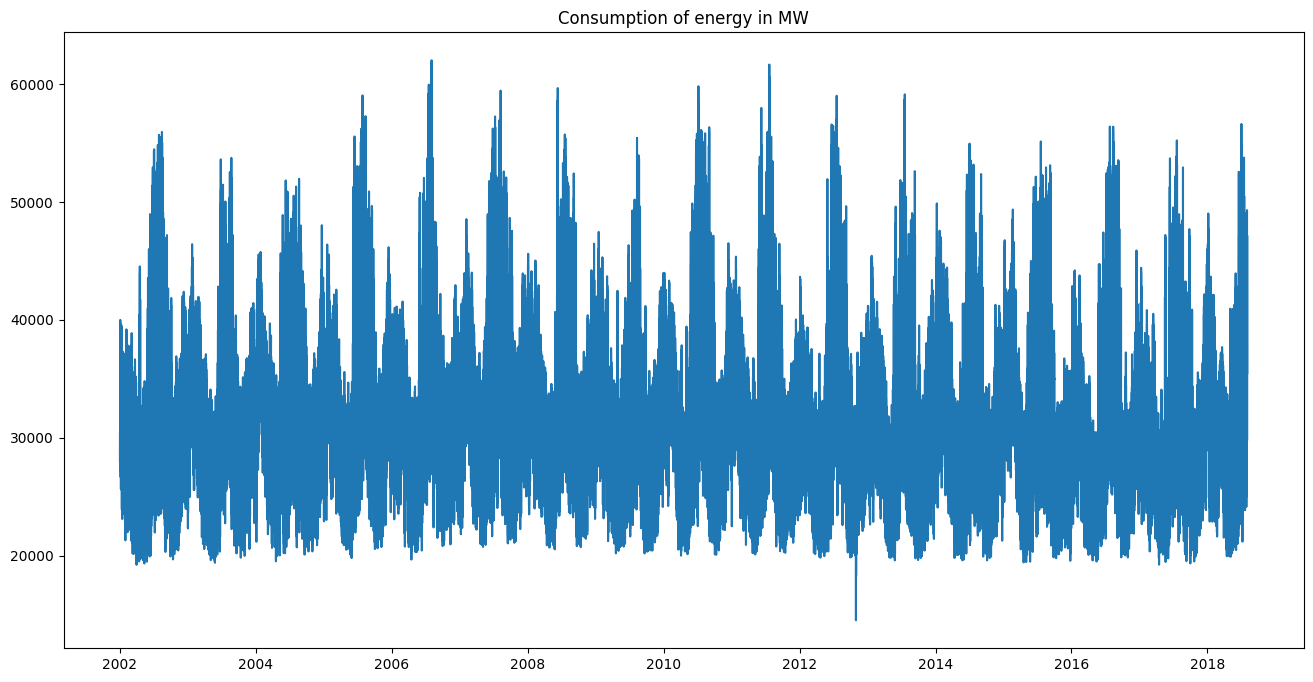

In [4]:
plt.figure(figsize=(16,8))
plt.title('Consumption of energy in MW')
plt.plot(df['Value'])
plt.show()

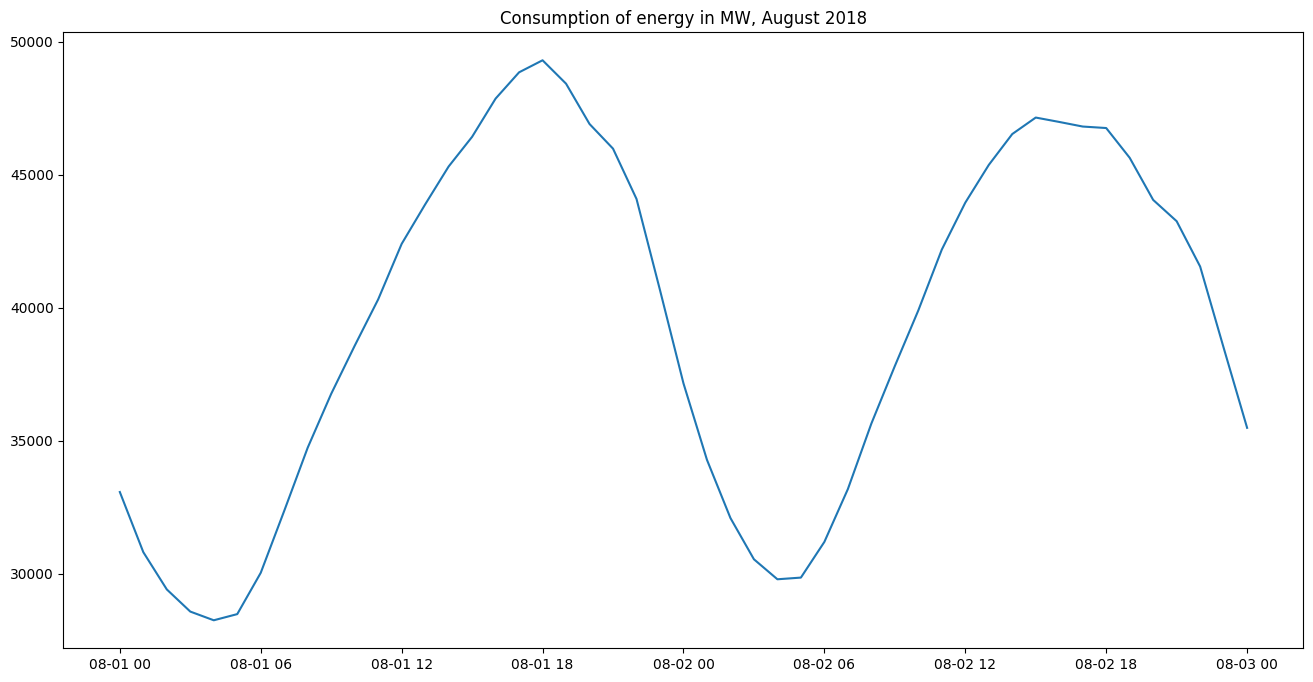

In [5]:
plt.figure(figsize=(16,8))
plt.title('Consumption of energy in MW, August 2018')
plt.plot(df[(df.index.year==2018) & (df.index.month==8)]['Value'])
plt.show()

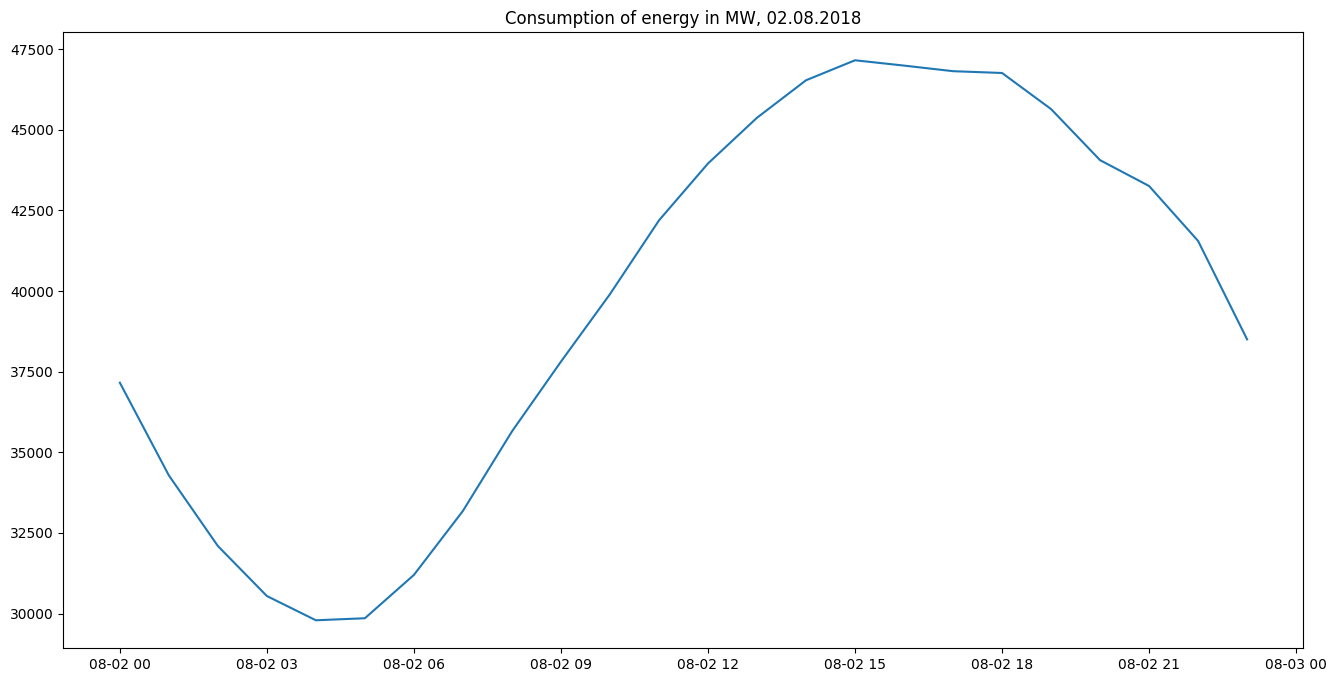

In [6]:
plt.figure(figsize=(16,8))
plt.title('Consumption of energy in MW, 02.08.2018')
plt.plot(df[(df.index.year==2018) & (df.index.month==8) & (df.index.day==2)]['Value'])
plt.show()

In [7]:
train = df[df.index.year<2018]
test = df[df.index.year>=2018]

scaled = MinMaxScaler(feature_range=(0,1))
train_scaled = scaled.fit_transform(train['Value'].values.reshape(-1, 1))

X_train = []
y_train = []
for i in range(50,len(train_scaled)):
    X_train.append(train_scaled[i-50:i,0])
    y_train.append(train_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# Model

In [8]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)),
    
    LSTM(units=50, return_sequences=True),    
    LSTM(units=50, return_sequences=True),
    LSTM(units=50),    
    Dense(units=1),
])

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
history = model.fit(X_train, y_train ,epochs=30, batch_size=64)

Epoch 1/30
2191/2191 [==============================] - 234s 103ms/step - loss: 0.0034 - mse: 0.0034 - mae: 0.0433 - mape: 642.3418
Epoch 2/30
2191/2191 [==============================] - 224s 102ms/step - loss: 5.0345e-04 - mse: 5.0345e-04 - mae: 0.0158 - mape: 235.7512
Epoch 3/30
2191/2191 [==============================] - 224s 102ms/step - loss: 1.2079e-04 - mse: 1.2079e-04 - mae: 0.0083 - mape: 177.2626
Epoch 4/30
2191/2191 [==============================] - 231s 105ms/step - loss: 1.0132e-04 - mse: 1.0132e-04 - mae: 0.0075 - mape: 134.8620
Epoch 5/30
2191/2191 [==============================] - 225s 103ms/step - loss: 8.9789e-05 - mse: 8.9789e-05 - mae: 0.0070 - mape: 108.9938
Epoch 6/30
2191/2191 [==============================] - 224s 102ms/step - loss: 7.9963e-05 - mse: 7.9963e-05 - mae: 0.0066 - mape: 31.8221
Epoch 7/30
2191/2191 [==============================] - 226s 103ms/step - loss: 7.4008e-05 - mse: 7.4008e-05 - mae: 0.0063 - mape: 6.4976
Epoch 8/30
2191/2191 [=========

# Predictions

In [10]:
dataset_total = df['Value']
inputs = dataset_total[len(dataset_total)-len(test['Value'].values) - 50:].values
inputs = inputs.reshape(-1,1)
inputs  = scaled.transform(inputs)

In [11]:
X_test = []
for i in range(50,len(inputs)):
    X_test.append(inputs[i-50:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_value = model.predict(X_test)
predicted_value = scaled.inverse_transform(predicted_value)

161/161 [==============================] - 6s 25ms/step


In [12]:
predictions = pd.DataFrame()
predictions['Actuals'] = test['Value']
predictions['Predictions'] = predicted_value

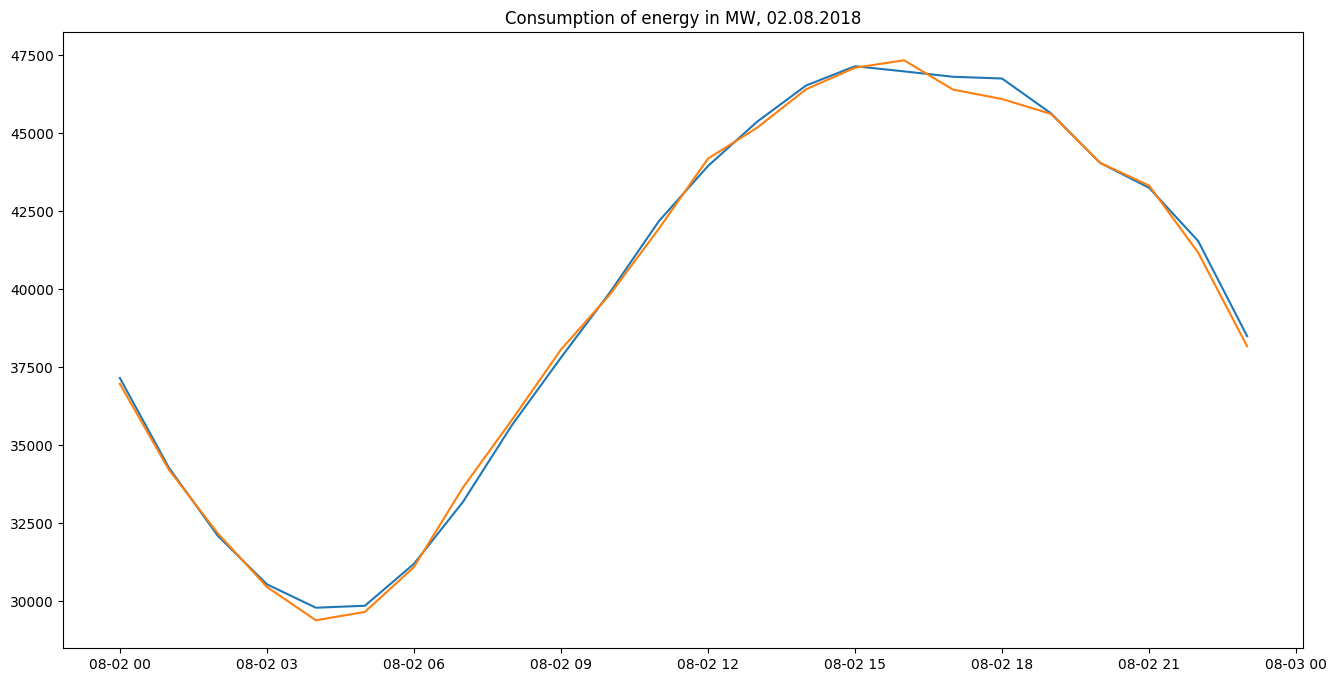

In [13]:
plt.figure(figsize=(16,8))
plt.title('Consumption of energy in MW, 02.08.2018')
plt.plot(predictions[(predictions.index.year==2018) & (predictions.index.month==8) & (predictions.index.day==2)]['Actuals'], label='Actuals')
plt.plot(predictions[(predictions.index.year==2018) & (predictions.index.month==8) & (predictions.index.day==2)]['Predictions'], label='Predictions')
plt.show()

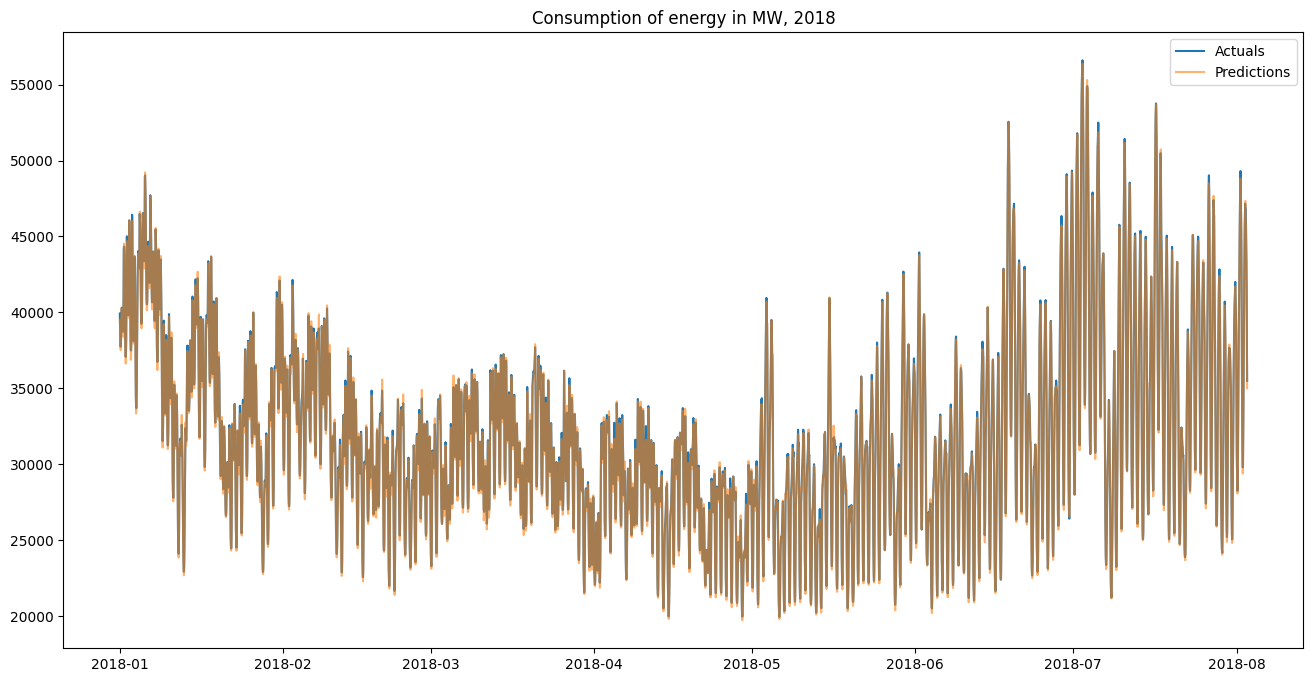

In [14]:
plt.figure(figsize=(16,8))
plt.title('Consumption of energy in MW, 2018')
plt.plot(predictions['Actuals'], label='Actuals')
plt.plot(predictions['Predictions'], label='Predictions', alpha=0.6)
plt.legend()
plt.show()